<a href="https://colab.research.google.com/github/Pawcio93/PlantPathology3/blob/main/PlantPathology3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries

In [ ]:
import time
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import OrderedDict

from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Input, GlobalMaxPool2D
from keras.optimizers import Adam
# Keras Tuner
!pip install keras-tuner
from kerastuner.tuners import RandomSearch
import kerastuner as kt
from kerastuner import HyperModel

# Tensorboard
%load_ext tensorboard
import tensorflow as tf
import datetime
# Clear any logs from previous runs
# rm -rf ./logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Data import

In [ ]:
# Data import
IMAGE_PATH = "/content/drive/MyDrive/PlantPathology/images"
TRAIN_PATH = "/content/drive/MyDrive/PlantPathology/train.csv"
TEST_PATH = "/content/drive/MyDrive/PlantPathology/test.csv"

test = pd.read_csv(TEST_PATH)
train = pd.read_csv(TRAIN_PATH)
print("Train dataset shape - {}".format(train.shape))
print("Test dataset shape - {}".format(test.shape))

Train dataset shape - (1821, 5)
Test dataset shape - (1821, 1)


In [ ]:
# Dataset overview
train.head(5)

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


# Data overview

In [ ]:
# Creating a dictionary with sum of instances of every class in dataset
plant_state = dict()
for column in ["healthy","multiple_diseases","rust","scab"]:
    counts = pd.DataFrame(train[column].value_counts())
    plant_state[column] = counts.iloc[1,0]

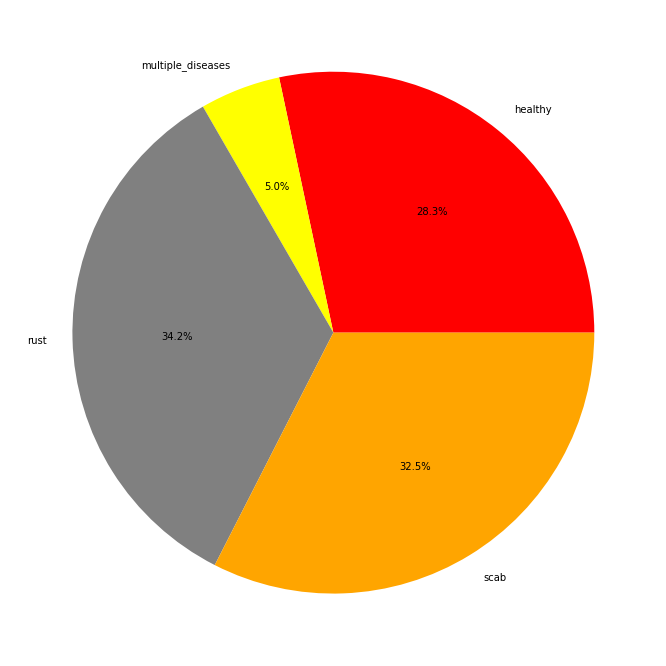

In [ ]:
# Pie chart which is showin classes frequency in dataset
fig = figure(figsize=(16,12))
plt.pie(plant_state.values(),labels = plant_state.keys(), colors=["red","yellow","grey","orange"], autopct='%1.1f%%')
plt.show()

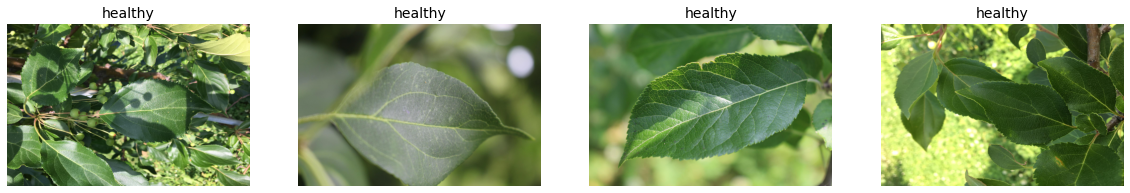

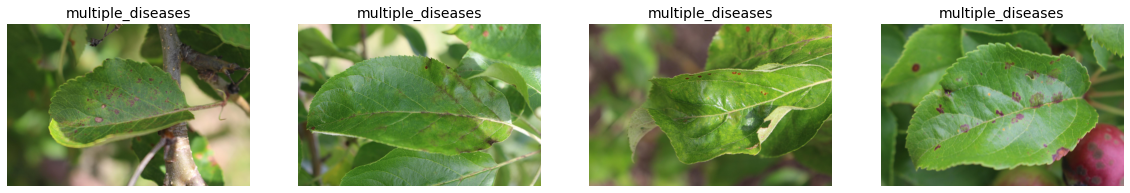

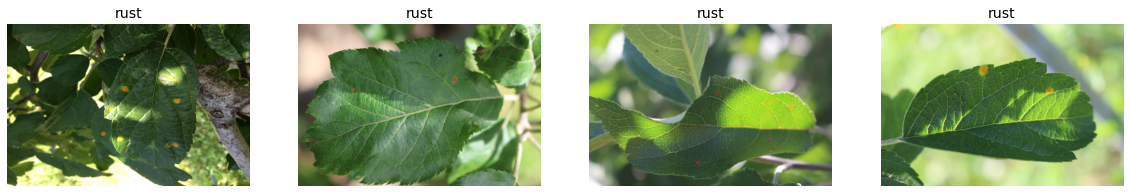

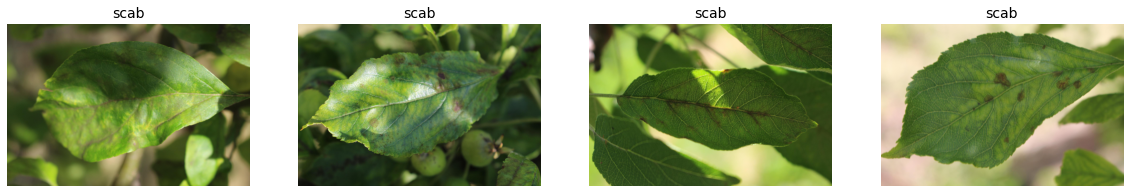

In [ ]:
# Images Overview
def ImageProbe(images, typ):
    fig = figure(figsize=(20,16))
    number_of_images = len(images)
    for i in range(number_of_images):
        a=fig.add_subplot(1,number_of_images,i+1)
        a.set_title(typ, fontsize = 14)
        image = imread(os.path.join(IMAGE_PATH,images[i]))
        imshow(image)
        axis('off')
        
col=train.columns[1:5]
for column in col:
    images = (train[train[column].apply(lambda x: x == 1)]["image_id"].sample(4).values) + ".jpg"
    ImageProbe(images, column)

# Data preparation

In [ ]:
#Adding the full image filname to easily read it from ImageDataGenerator
train["image_name"] = train.image_id+".jpg"
test["image_name"]  = test.image_id+".jpg"
train.head(5)

,image_id,healthy,multiple_diseases,rust,scab,image_name
0,Train_0,0,0,0,1,Train_0.jpg
1,Train_1,0,1,0,0,Train_1.jpg
2,Train_2,1,0,0,0,Train_2.jpg
3,Train_3,0,0,1,0,Train_3.jpg
4,Train_4,1,0,0,0,Train_4.jpg


In [ ]:
# Listing labels columns
labels=train.columns[1:5]

In [ ]:
# Setting input image size and batch size
img_height = 600
img_width = 400
batch_size = 32 # numbers of images in one batch 

# Building model

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='glorot_uniform', 
                 bias_initializer='zeros',  input_shape=(img_height, img_width, 3), padding='same')) # Convolutiona layer is searching for features like edges or corners using dot porduct
                 # of image parts and convolutional matrix
model.add(Conv2D(32, (3, 3),kernel_initializer='glorot_uniform', bias_initializer='zeros', 
                 activation='relu', padding='same'))
model.add(Dropout(0.1)) ## This layer is dropping random nodes from neural network to prevent overfitting during learning process
model.add(MaxPool2D(pool_size=(2, 2))) ## pooling layer is reducing the size of image to decrease the computional power needed to perfmorm learning 

model.add(Conv2D(64, (3, 3),kernel_initializer='glorot_uniform', bias_initializer='zeros', activation='relu'))
model.add(Conv2D(64, (3, 3),kernel_initializer='glorot_uniform', bias_initializer='zeros', activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (5, 5),kernel_initializer='glorot_uniform', bias_initializer='zeros', activation='relu'))
model.add(Conv2D(128, (5,5),kernel_initializer='glorot_uniform', bias_initializer='zeros', activation='relu'))
model.add(Dropout(0.1))
model.add(GlobalMaxPool2D())

model.add(Dropout(0.1))
model.add(Dense(4, activation='softmax')) ## Dense layer builds an architecture where all nods from this layer are connected to all nods from prevoius layer, we have 4 classes so we have 4 nods
# in the last layer and all nods from previous layer are connected to each class and are able to affect it

optimizerAdam = Adam(lr=0.00125, amsgrad=True) ## optimizer is basicaly a function which is resposible for changing the weights of all nods in CNN

### Since the goal is to classify correctly an image to particular class metric which is neccecary to determined performence of our model is accuracy of our classification
model.compile(loss="categorical_crossentropy", optimizer=optimizerAdam, metrics=["accuracy"])

#Print a summary of the model:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 300, 200, 32)      896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 300, 200, 32)      9248      
_________________________________________________________________
dropout_4 (Dropout)          (None, 300, 200, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 150, 100, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 148, 98, 64)       18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 146, 96, 128)      73856     
_________________________________________________________________
dropout_5 (Dropout)          (None, 146, 96, 128)     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
## Performing data augmentation to make images more different and unusual which makes the model more flexible to changes and will increase accuraccy
train_dataGenerator = ImageDataGenerator(rescale=1./255,
    shear_range=0,
    zoom_range=(1, 1.3),
    rotation_range = 360,
    brightness_range = (0.7, 1.3),                                                   
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2)

In [ ]:
### Generating train input dataset for model training
train_generator = train_dataGenerator.flow_from_dataframe(
    dataframe=train,x_col='image_name', y_col=labels,
    directory=IMAGE_PATH, target_size=(img_height, img_width),
    batch_size=batch_size,class_mode='raw', subset='training') 

Found 1457 validated image filenames.


In [ ]:
### Generating validation input dataset for model training
validation_generator = train_dataGenerator.flow_from_dataframe(
    dataframe=train,x_col='image_name', y_col=labels,
    directory=IMAGE_PATH, target_size=(img_height, img_width),
    batch_size=batch_size, class_mode='raw', subset='validation')

Found 364 validated image filenames.


# Model Learning

In [ ]:
### declaring number of epochs (number of iteration on which our training is going thru whole dataset)
nb_epochs = 100
### Learning
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = nb_epochs,
    callbacks=[tensorboard_callback],
    )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
22/22 [==============================] - 513s 24s/step - loss: 1.3028 - accuracy: 0.3346 - val_loss: 1.2472 - val_accuracy: 0.3156
Epoch 2/100
22/22 [==============================] - 109s 4s/step - loss: 1.2611 - accuracy: 0.3531 - val_loss: 1.2477 - val_accuracy: 0.3250
Epoch 3/100
22/22 [==============================] - 96s 5s/step - loss: 1.2631 - accuracy: 0.3410 - val_loss: 1.2221 - val_accuracy: 0.3906
Epoch 4/100
22/22 [==============================] - 98s 5s/step - loss: 1.2060 - accuracy: 0.3870 - val_loss: 1.2440 - val_accuracy: 0.3469
Epoch 5/100
22/22 [==============================] - 98s 5s/step - loss: 1.2237 - accuracy: 0.3715 - val_loss: 1.2433 - val_accuracy: 0.3031
Epoch 6/100
22/22 [==============================] - 98s 5s/step - loss: 1.2265 - accuracy: 0.3402 - val_loss: 1.2132 - val_accuracy: 0.4125
Epoch 7/100
22/22 [==============================] - 97s 5s/step - loss: 1.2132 - accuracy: 0.3747 - val_loss: 1.2354 - val_accuracy: 0.3875
Epoch 8/10

# Accuracy and Loss figures

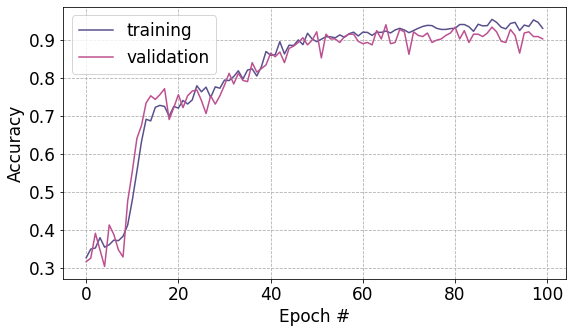

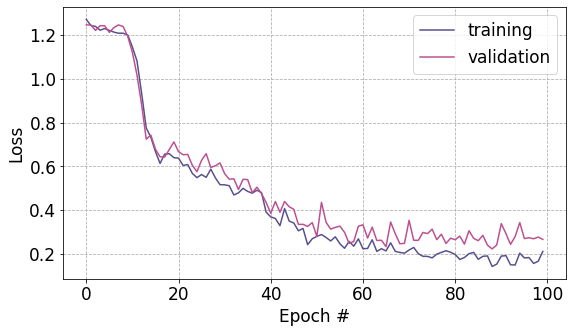

In [ ]:
# summarized history for accuracy
fs = 17
fig = plt.figure(figsize=(9,5))
fig.patch.set_facecolor('xkcd:white')
plt.plot(history.history['accuracy'], color='#58508d')
plt.plot(history.history['val_accuracy'], color='#bc5090')
plt.ylabel('Accuracy',fontsize=fs)
plt.xlabel('Epoch #',fontsize=fs)
plt.legend(['training', 'validation'],fontsize=fs)
plt.grid('both', linestyle='--')
plt.xticks(fontsize = fs)
plt.yticks(fontsize = fs)
plt.show()

# summarized history for loss
fig = plt.figure(figsize=(9,5))
fig.patch.set_facecolor('xkcd:white')
plt.plot(history.history['loss'], color='#58508d')
plt.plot(history.history['val_loss'], color='#bc5090')
plt.ylabel('Loss',fontsize=fs)
plt.xlabel('Epoch #',fontsize=fs)
plt.legend(['training', 'validation'],fontsize=fs)
plt.grid('both', linestyle='--')
plt.xticks(fontsize = fs)
plt.yticks(fontsize = fs)
plt.show()

# Conclusions


 - Jak widać na wykresach metryki accuracy i funckja loss stabilizują się dla obu zbiorów około 60 epoki i dalej wzrost jest już niewielki (przy około 80 epoce jest już praktycznie zerowy)
 - Uzyskano skuteczność klasyfikacji w zbiorze testowym na ok. 90% Co jest wynikiem dość dobrym ze względu na to, że możnaby użyć jeszcze bardziej złożonej sieci o większej ilości warstw, nie wykonano także tuningu parametrów.
 - Co do tuningu hiperparametrów to w pakiecie załączony jest także plik PlantPathology3 - tuning_attempt.ipynb z nieudaną próbą zastosowania Keras Tuner. Błąd jest najprawdopodobniej spowodowny tym, że Keras Tuner nie jest w stanie przyjąć jako input zdjęcia w formie odniesienia do źródła tak jak metoda flow_from_dataframe, niestety nie zdążyłem zmienić już formatu obrazów na szyk liczbowy w Numpy aby spróbować wprowadzić dane w sposób akceptowalny dla Tunera. Zatem Tunning hiperparametrów okazał sie największym problemem w tym zadaniu, którego juz nie zdążyłem obejść.
 - w celu poprawienia wydajności z pewnością możnaby spróbować tuningu takich hiperparametrów jak
  - learning rate
  - liczba filtrów w warstwach konwolucyjnych
  - wielkość macierzy poolingu
  - procent odrzuconych neuronów w dropout
  - funkcje aktywacyjne, np tanh lub sigmoid
  - optymizery jak na przykład SGD z momentem lub Adadelta
  - można też pomanipulować rozdzielczością zdjęc na wejściu i wielkością partii zdjęć



 - Warto by również zoptymalizować parametry w procesie Data Augmentation
 - naszym problemem jest wieloklasowa klasyfikacja a więc metryką wybraną do mierzenia tego jak model sobie radzi jest Accuracy ('celność'). Metryka da daje nam jasną informacje na temat tego jaki procent naszych predykcji był trafny co w przypadku tego rodzaju problemu jest informacja kluczową